In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np
from shutil import copyfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import functional as F
from torchvision.transforms import ToTensor
import albumentations as A
import pickle
import datetime

import os
import shutil
# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
!tree -d data

data
├── b2u_g123_second
├── b2u_g123_second_mask
├── b2u_g209_stride200
├── b2u_g209_stride200_mask
├── b2u_g210_stride200
├── b2u_g210_stride200_mask
├── b2u_g46_second
├── b2u_g46_second_mask
├── G-123
├── G-209_Helios
├── G-210_Helios
├── G46
├── test
│   ├── img
│   ├── mask
│   └── noisy_img
└── train
    ├── img
    ├── mask
    └── noisy_img

20 directories


In [3]:
torch.random.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
#Dataset

class Microscopy(Dataset):
    def __init__(self, img_path, label_path,  n_class,img_channels=1, transform=None, crop_size=(768, 1024), crop_position = None ):
        self.img_path = img_path
        self.label_path = label_path
        self.img_channels = img_channels
        self.transform = transform
        self.n_class = n_class
        self.files = []
        self.to_tensor = ToTensor()
        self.crop_size = crop_size
        self.crop_position = crop_position
        self.preprocess()

    def preprocess(self):
        
        img_filenames = os.listdir(self.img_path)
        
        for img_file in img_filenames:
            img_path = os.path.join(self.img_path, img_file.split('.')[0])
            label_path = os.path.join(self.label_path, img_file.split('.')[0])
            # for check
            

            if os.path.isfile(img_path + '.tif' ) == False or os.path.isfile(label_path  + '.png') == False:
                raise Exception(f"There are not a file or no couple for img {img_file}")
        
            self.files.append([img_path + '.tif', label_path  + '.png'])
        print('Finished preprocessing the Microscopy dataset')
        

    def __getitem__(self, index):
        
        img_path, label_path = self.files[index]
        
        if self.img_channels == 1:
            image = cv2.imread(img_path, 0)
        else:
            image = cv2.imread(img_path, 3)
        mask = cv2.imread(label_path, 0 )
#         mask[mask == 255] = 1
        mask.astype(np.bool_).astype(np.uint8)
        if self.crop_position is not None:
            c_pos = self.crop_position
        else:
            if self.img_channels == 1:
                c_pos = (np.random.randint(0,image.shape[0] - self.crop_size[0]),
                          np.random.randint(0,image.shape[1] - self.crop_size[1]))
            else:
                c_pos = (np.random.randint(0,image.shape[0] - self.crop_size[0]),
                          np.random.randint(0,image.shape[1] - self.crop_size[1]))
            
        if self.img_channels == 1:
            image = image[c_pos[0]:c_pos[0] + self.crop_size[0], c_pos[1]:c_pos[1] + self.crop_size[1]]
        else:
            image = image[c_pos[0]:c_pos[0] + self.crop_size[0], c_pos[1]:c_pos[1] + self.crop_size[1],:]
        mask = mask[c_pos[0]:c_pos[0] + self.crop_size[0], c_pos[1]:c_pos[1] + self.crop_size[1]]
        
        if self.transform is not None:
            transformed = self.transform(image=np.asarray(image), mask=np.asarray(mask))

            image = transformed['image']
            mask = transformed['mask']
        
        
        image = self.to_tensor(image.copy())
        mask = self.to_tensor(mask.copy()).squeeze()
        mask = F.one_hot(mask.long(), self.n_class + 0).permute(2,0,1)
        
        
#         if mask.shape[0] < self.n_class:
#             n_zeros = self.n_class - mask.shape[0]
#             mask = torch.cat((mask, torch.zeros((n_zeros, mask.shape[1],mask.shape[2]))),dim=0)
        
        return image, mask

    def __len__(self):
        """Return the number of images."""
        return len(self.files)

In [5]:
#batch_size = 1
batch_size = 2
# im_size = (384,512)
im_size = (768,1024)
num_workers = 3
# im_size = (128,128)
#im_size = (256,256)
label_list = ['holes', 'surface']

train_transform = A.Compose([
    A.Resize(*im_size),
    A.Rotate(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
])
   
train_img_path = 'data/train/noisy_img'
train_label_path = 'data/train/mask'
train_set = Microscopy(train_img_path, train_label_path, n_class=len(label_list), transform=train_transform,
                       crop_size=(768, 1024), crop_position = None)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=num_workers)

test_transform = A.Compose([
    A.Resize(*im_size),
])

   
test_img_path = 'data/test/noisy_img'
test_label_path = 'data/test/mask'
test_set = Microscopy(test_img_path, test_label_path, n_class=len(label_list), transform=test_transform,
                       crop_size=(768, 1024), crop_position = (1000,1000))
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size, num_workers=num_workers)

print('Train size', len(train_set))
print('Test size', len(test_set))


Finished preprocessing the Microscopy dataset
Finished preprocessing the Microscopy dataset
Train size 1057
Test size 55


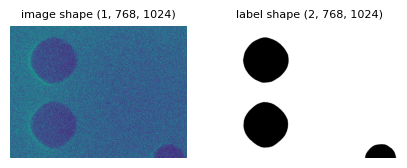

In [6]:
def plot_img(loader,ind):
    size = 10
    dataset = loader.dataset
    fig, ax = plt.subplots(1,2,figsize=(size/2,size))
    ax[0].axis('off')
    ax[1].axis('off')

    img, mask = dataset[ind]#[0][:,:,:]
    #mask = dataset[ind][1][:,:,:]
    
    ax[0].set_title(f'image shape {tuple(img.shape)}', fontsize = 8)
    ax[1].set_title(f'label shape {tuple(mask.shape)}', fontsize = 8)
    ax[0].imshow(img.permute(1,2,0))
    preds = torch.argmax(mask, dim=0)[None,:,:]
    ax[1].imshow(preds.permute(1,2,0), cmap='gray')
plot_img(test_loader,2)   

In [7]:
def iou_dice_score(preds,target_mask,n_classes,delta = 1e-7):
    preds = torch.argmax(preds, dim=1)
    preds_mask = F.one_hot(preds, n_classes).permute(0,3,1,2)
    
    logical_and = torch.logical_and(preds_mask, target_mask)
    logical_or = torch.logical_or(preds_mask, target_mask)
    
    overlap = torch.sum(logical_and, dim =(2,3))
    union = torch.sum(logical_or, dim =(2,3))
    
    
    sum_of_areas = torch.sum(preds_mask, dim =(2,3)) + torch.sum(target_mask, dim =(0,2,3))
    
    iou_array = overlap/(union + delta)
    
    dice_array = 2*overlap/(sum_of_areas + delta)
    
    return iou_array, dice_array

In [8]:
class Encoder_Block(torch.nn.Module):
    def __init__(self, inp_channels, out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.pooling = torch.nn.MaxPool2d(2)
    def forward(self,x):
        int_out = self.model(x)
        return self.pooling(int_out), int_out

class Decoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
    def forward(self,x,enc_x):
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)
    
class Unet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=64):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block(hidden_size*16,hidden_size*8),
            Decoder_Block(hidden_size*8,hidden_size*4),
            Decoder_Block(hidden_size*4,hidden_size*2),
            Decoder_Block(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same")
        
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)   

In [9]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    
    for model_input, target in tqdm(loader):
        
        model_input = model_input.to(device)
        target = target.to(device)
        
        model_output = clf(model_input)
        
        loss = criterion(model_output,target.to(torch.float ))

        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss


def epoch_test(loader, clf, criterion, n_classes):
    clf.eval()
        
    iou_all = None
    dice_all = None
    for index, m_t in enumerate(tqdm(loader)):
        model_input = m_t[0]
        target = m_t[1]
        
        with torch.no_grad():
            
            model_input = model_input.to(device)
            target = target.to(device)
            
            model_output = clf(model_input)
            
            loss = criterion(model_output,target.to(torch.float ))
            iou, dice = iou_dice_score(model_output,target,n_classes)
            
            if iou_all is None:
                iou_all = iou
                dice_all = dice
            else:
                iou_all = torch.cat((iou_all, iou),dim=0)
                dice_all = torch.cat((dice_all, dice),dim=0)
                
    iou_mean = iou_all.mean(dim=0)
    dice_mean = dice_all.mean(dim=0)

    return iou_mean, dice_mean

# The function which you are going to use for model training
def train(train_loader, test_loader, clf,n_classes, criterion, opt, n_epochs=10):
    now = datetime.datetime.now()
    os.makedirs('models', exist_ok=True)
    models_dir = f'models/unet_d{now.day}_h{now.hour}'
    os.makedirs(models_dir, exist_ok=False)
    
    all_iou = dict(zip(label_list, [[] for x in range(len(label_list))]))
    all_dice = dict(zip(label_list, [[] for x in range(len(label_list))]))

    #for epoch in tqdm(range(n_epochs)):
    for epoch in range(n_epochs):
        train_loss = epoch_train(train_loader, clf, criterion, opt)
        iou_mean, dice_mean = epoch_test(test_loader, clf, criterion, n_classes)
        
        iou_map = dict(zip(label_list, iou_mean.tolist()))
        dice_map = dict(zip(label_list, dice_mean.tolist()))
        
        #Save model
        if (epoch+1) % 10 == 0:
            torch.save(clf, os.path.join(models_dir, f'unet_{im_size}_{epoch+1}ep.pth'))
        
        for label in label_list:
            all_iou[label].append(iou_map[label])
            all_dice[label].append(dice_map[label])
        

        print(f'[Epoch {epoch + 1}]')
        
        print(f'Test iou scores:')
        for key, value in iou_map.items():
            print (key, " {:.3f}".format(value))
        print('Test dice scores:')
        for key, value in dice_map.items():
            print (key, " {:.3f}".format(value))
            
    return all_iou, all_dice

In [10]:
unet = Unet(1,len(label_list)).to(device)
optimizer = torch.optim.Adam(unet.parameters(),lr=0.0003)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
#train unet
# 50 ep
all_iou, all_dice = train(train_loader, test_loader,unet, len(label_list), criterion,optimizer,n_epochs=40)

100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 1]
Test iou scores:
holes  0.639
surface  0.938
Test dice scores:
holes  0.484
surface  0.655


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 2]
Test iou scores:
holes  0.742
surface  0.890
Test dice scores:
holes  0.540
surface  0.613


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


[Epoch 3]
Test iou scores:
holes  0.750
surface  0.869
Test dice scores:
holes  0.544
surface  0.598


100%|██████████| 28/28 [00:06<00:00,  4.03it/s]


[Epoch 4]
Test iou scores:
holes  0.732
surface  0.871
Test dice scores:
holes  0.535
surface  0.600


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 5]
Test iou scores:
holes  0.745
surface  0.846
Test dice scores:
holes  0.551
surface  0.583


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


[Epoch 6]
Test iou scores:
holes  0.752
surface  0.871
Test dice scores:
holes  0.526
surface  0.594


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


[Epoch 7]
Test iou scores:
holes  0.733
surface  0.866
Test dice scores:
holes  0.526
surface  0.591


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 8]
Test iou scores:
holes  0.662
surface  0.941
Test dice scores:
holes  0.495
surface  0.657


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 9]
Test iou scores:
holes  0.747
surface  0.879
Test dice scores:
holes  0.541
surface  0.607


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 10]
Test iou scores:
holes  0.717
surface  0.909
Test dice scores:
holes  0.522
surface  0.634


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


[Epoch 11]
Test iou scores:
holes  0.724
surface  0.937
Test dice scores:
holes  0.531
surface  0.651


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 12]
Test iou scores:
holes  0.719
surface  0.909
Test dice scores:
holes  0.518
surface  0.634


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 13]
Test iou scores:
holes  0.754
surface  0.872
Test dice scores:
holes  0.539
surface  0.600


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 14]
Test iou scores:
holes  0.699
surface  0.946
Test dice scores:
holes  0.511
surface  0.657


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 15]
Test iou scores:
holes  0.751
surface  0.884
Test dice scores:
holes  0.540
surface  0.610


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 16]
Test iou scores:
holes  0.760
surface  0.883
Test dice scores:
holes  0.551
surface  0.608


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 17]
Test iou scores:
holes  0.668
surface  0.882
Test dice scores:
holes  0.499
surface  0.618


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


[Epoch 18]
Test iou scores:
holes  0.723
surface  0.941
Test dice scores:
holes  0.525
surface  0.652


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 19]
Test iou scores:
holes  0.738
surface  0.902
Test dice scores:
holes  0.533
surface  0.626


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


[Epoch 20]
Test iou scores:
holes  0.700
surface  0.947
Test dice scores:
holes  0.503
surface  0.658


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


[Epoch 21]
Test iou scores:
holes  0.645
surface  0.941
Test dice scores:
holes  0.485
surface  0.657


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 22]
Test iou scores:
holes  0.726
surface  0.953
Test dice scores:
holes  0.533
surface  0.660


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 23]
Test iou scores:
holes  0.717
surface  0.948
Test dice scores:
holes  0.528
surface  0.657


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


[Epoch 24]
Test iou scores:
holes  0.738
surface  0.925
Test dice scores:
holes  0.538
surface  0.642


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 25]
Test iou scores:
holes  0.745
surface  0.880
Test dice scores:
holes  0.518
surface  0.609


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 26]
Test iou scores:
holes  0.693
surface  0.943
Test dice scores:
holes  0.517
surface  0.656


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


[Epoch 27]
Test iou scores:
holes  0.728
surface  0.902
Test dice scores:
holes  0.529
surface  0.626


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 28]
Test iou scores:
holes  0.747
surface  0.871
Test dice scores:
holes  0.534
surface  0.598


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


[Epoch 29]
Test iou scores:
holes  0.734
surface  0.882
Test dice scores:
holes  0.528
surface  0.609


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 30]
Test iou scores:
holes  0.715
surface  0.944
Test dice scores:
holes  0.536
surface  0.655


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 31]
Test iou scores:
holes  0.751
surface  0.887
Test dice scores:
holes  0.543
surface  0.613


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 32]
Test iou scores:
holes  0.708
surface  0.939
Test dice scores:
holes  0.507
surface  0.653


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


[Epoch 33]
Test iou scores:
holes  0.735
surface  0.878
Test dice scores:
holes  0.528
surface  0.604


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


[Epoch 34]
Test iou scores:
holes  0.668
surface  0.911
Test dice scores:
holes  0.498
surface  0.635


100%|██████████| 28/28 [00:06<00:00,  4.00it/s]


[Epoch 35]
Test iou scores:
holes  0.711
surface  0.885
Test dice scores:
holes  0.527
surface  0.616


100%|██████████| 28/28 [00:07<00:00,  4.00it/s]


[Epoch 36]
Test iou scores:
holes  0.738
surface  0.886
Test dice scores:
holes  0.526
surface  0.614


100%|██████████| 28/28 [00:06<00:00,  4.02it/s]


[Epoch 37]
Test iou scores:
holes  0.688
surface  0.949
Test dice scores:
holes  0.517
surface  0.659


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


[Epoch 38]
Test iou scores:
holes  0.709
surface  0.916
Test dice scores:
holes  0.512
surface  0.641


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


[Epoch 39]
Test iou scores:
holes  0.663
surface  0.910
Test dice scores:
holes  0.497
surface  0.639


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]

[Epoch 40]
Test iou scores:
holes  0.734
surface  0.905
Test dice scores:
holes  0.534
surface  0.629


In [13]:
now = datetime.datetime.now()


os.makedirs('logs', exist_ok=True)
log_dir = f'logs/unet_d{now.day}_h{now.hour}'
os.makedirs(log_dir, exist_ok=False)



all_iou_file = os.path.join(log_dir,'all_iou.pkl')
with open(all_iou_file, 'wb') as f:
    pickle.dump(all_iou, f)
    
all_dice_file = os.path.join(log_dir,'all_dice.pkl')
with open(all_dice_file, 'wb') as f:
    pickle.dump(all_dice, f)

In [27]:
with open(all_dice_file, 'rb') as f:
    data = pickle.load(f)

data

{'holes': [0.4890190064907074,
  0.4760792553424835,
  0.4574418067932129,
  0.4810224175453186,
  0.48831576108932495,
  0.46834641695022583,
  0.49116116762161255,
  0.48305726051330566,
  0.493852436542511,
  0.4907653331756592,
  0.4473343789577484,
  0.49494147300720215,
  0.4946599006652832,
  0.5115771293640137,
  0.481015145778656,
  0.4981997609138489,
  0.49096137285232544,
  0.5091121196746826,
  0.48754385113716125,
  0.5077356100082397,
  0.4886417090892792,
  0.5117125511169434,
  0.5088229179382324,
  0.4902830719947815,
  0.5093362927436829,
  0.4895245432853699,
  0.5085200071334839,
  0.500783383846283,
  0.4925021529197693,
  0.48540666699409485,
  0.48011165857315063,
  0.4875071346759796,
  0.4752242863178253,
  0.4932697117328644,
  0.49447956681251526,
  0.4935426712036133,
  0.5064312815666199,
  0.5056097507476807,
  0.5147325396537781,
  0.48108744621276855,
  0.5016077160835266,
  0.5109766125679016,
  0.49844151735305786,
  0.4767870604991913,
  0.4942763149

In [1]:
def plot_model_output(loader,ind,model,title=None, n_classes=2):
    size = 3
    dataset = loader.dataset
    fig, ax = plt.subplots(1,3,figsize=(size*3,size))
    ax[0].axis('off')
    ax[1].axis('off')

    data = dataset[ind]
    img = data[0][:,:,:]
    mask = data[1][:,:,:]
    out = (model(img[None,:].to(device)).to('cpu')).view(n_classes,*im_size)
    
    iou, dice = iou_dice_score(out[None,:],mask[None,:],n_classes)
    
    iou_mean = iou.mean()
    dice_mean = dice.mean()
    
    ax[0].set_title(f'original image ', fontsize = 8)
    ax[1].set_title(f'label', fontsize = 8)
    ax[2].set_title(f'output, iou mean: {iou_mean:.3f}, dice mean: {dice_mean:.3f}', fontsize = 8)
    ax[0].imshow(img.permute(1,2,0))
    
    mask = torch.argmax(mask, dim=0)[None,:,:]
    ax[1].imshow(mask.permute(1,2,0))
    
    preds = out.detach()
    preds = torch.argmax(preds, dim=0)[None,:,:]
    
    ax[2].imshow(preds.permute(1,2,0))
    fig.suptitle(title)
plot_model_output(test_loader,1,unet,'')

NameError: name 'test_loader' is not defined